# Linear Regression - Variational Inference

Implementation of a linear regression model. Weights are estimated with Stochastic Variable Inference (SVI) using [PyTorch distributions](https://pytorch.org/docs/stable/distributions.html). 

$y \sim \mathcal{N}(\alpha x + \beta, \sigma)$


## Setting up the environment

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Define model

In [3]:
class LinearNormal(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros((3,)),
            torch.Tensor([10, 10, 1]) * torch.eye(3),
        )
        self.mean = torch.nn.Parameter(torch.randn((3,)))
        self.sigma = torch.nn.Parameter(torch.randn((3,)))
        
    def forward(self, x, sample=True):
        σ = torch.log(1 + torch.exp(self.sigma))
        dist = torch.distributions.MultivariateNormal(
            self.mean,
            σ * torch.eye(3),
        )
        if sample:
            alpha, beta, sigma = dist.rsample()
        else:
            alpha, beta, sigma = dist.mean
        
        m = alpha * x + beta
        s = torch.log(1 + torch.exp(sigma))
        y_hat = torch.distributions.Normal(m, s)
        kl_divergence = torch.distributions.kl.kl_divergence(dist, self.prior)
        return y_hat, kl_divergence

In [4]:
def compute_loss(model, x, y):
    y_hat, kl_divergence = model(x)
    return torch.mean(-y_hat.log_prob(y))

In [5]:
def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

def compute_rmse(model, x_test, y_test):
    model.eval()
    y_hat, _ = model(x_test, sample=False)
    pred = y_hat.sample()
    return torch.sqrt(torch.mean((pred - y_test)**2))

## Generate dataset

In [6]:
α_actual = 2.6
β_actual = 3.3
σ_actual = 0.7

In [7]:
def generate_samples(α, β, σ, min_x=-1, max_x=1, n_samples=500):
    x = np.linspace(min_x, max_x, n_samples)[:, np.newaxis]
    y = α * x + β
    dist = torch.distributions.Normal(torch.from_numpy(y), σ)
    return x, y, dist.sample().detach().numpy()

In [8]:
def plot_line(x, y, y_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=3)
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], alpha=0.8)
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    return ax

In [9]:
x, y, y_sample = generate_samples(α_actual, β_actual, σ_actual)

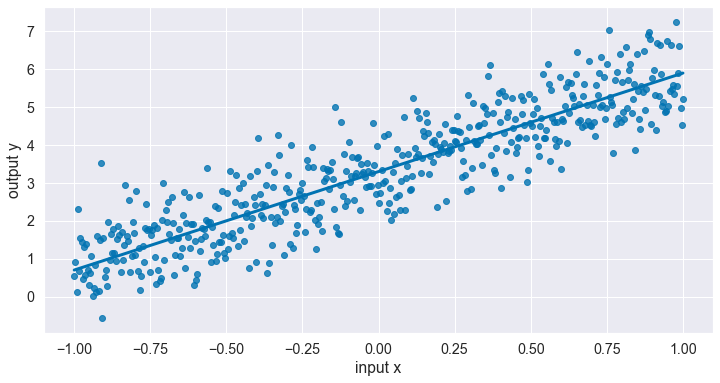

In [10]:
plot_line(x, y, y_sample);

## Fit linear model with variational inference

In [11]:
def train(model, optimizer, x_train, x_val, y_train, y_val, n_epochs, batch_size=64, print_every=10):
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        batch_indices = sample_batch_indices(x_train, y_train, batch_size)
        
        batch_losses_t, batch_losses_v, batch_rmse_v = [], [], []
        for batch_ix in batch_indices:
            b_train_loss = train_one_step(model, optimizer, x_train[batch_ix], y_train[batch_ix])

            model.eval()
            b_val_loss = compute_loss(model, x_val, y_val)
            b_val_rmse = compute_rmse(model, x_val, y_val)

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_rmse_v.append(b_val_rmse.detach().numpy())
            
        train_loss = np.mean(batch_losses_t)
        val_loss = np.mean(batch_losses_v)
        val_rmse = np.mean(batch_rmse_v)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1} | Validation loss = {val_loss:.4f} | Validation RMSE = {val_rmse:.4f}')
        
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_epochs + 1), val_losses, label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, val_losses


def sample_batch_indices(x, y, batch_size, rs=None):
    if rs is None:
        rs = np.random.RandomState()
    
    train_ix = np.arange(len(x))
    rs.shuffle(train_ix)
    
    n_batches = int(np.ceil(len(x) / batch_size))
    
    batch_indices = []
    for i in range(n_batches):
        start = i + batch_size
        end = start + batch_size
        batch_indices.append(
            train_ix[start:end].tolist()
        )

    return batch_indices

In [12]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [13]:
model = LinearNormal()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, weight_decay=1e-5)

In [14]:
x_train, x_test, y_train, y_test = compute_train_test_split(x, y_sample, test_size=0.2)

Epoch 1 | Validation loss = 2.9241 | Validation RMSE = 6.9634
Epoch 100 | Validation loss = 1.8937 | Validation RMSE = 1.8496
Epoch 200 | Validation loss = 1.2464 | Validation RMSE = 1.1442
Epoch 300 | Validation loss = 1.1188 | Validation RMSE = 1.1171
Epoch 400 | Validation loss = 1.1367 | Validation RMSE = 1.0144
Epoch 500 | Validation loss = 1.0793 | Validation RMSE = 1.0365
Epoch 600 | Validation loss = 1.0762 | Validation RMSE = 0.9811
Epoch 700 | Validation loss = 1.0844 | Validation RMSE = 1.0260
Epoch 800 | Validation loss = 1.0596 | Validation RMSE = 0.9475
Epoch 900 | Validation loss = 1.0768 | Validation RMSE = 1.0772
Epoch 1000 | Validation loss = 1.0654 | Validation RMSE = 1.0366
Epoch 1100 | Validation loss = 1.0628 | Validation RMSE = 0.9851
Epoch 1200 | Validation loss = 1.0592 | Validation RMSE = 0.9588
Epoch 1300 | Validation loss = 1.0843 | Validation RMSE = 1.0760
Epoch 1400 | Validation loss = 1.0590 | Validation RMSE = 1.0231
Epoch 1500 | Validation loss = 1.0792

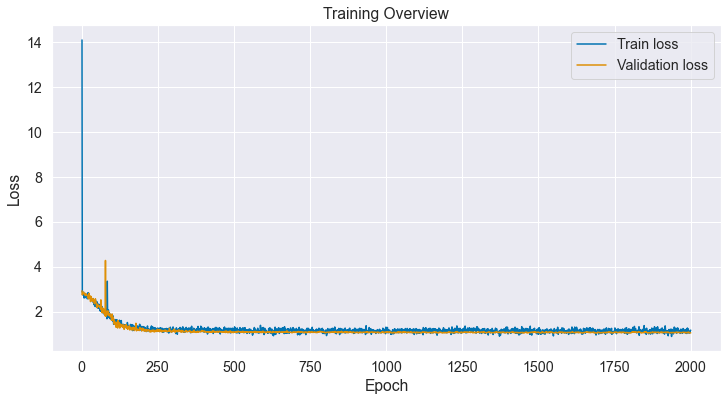

In [15]:
train(model, optimizer, x_train, x_test, y_train, y_test, n_epochs=2000, print_every=100);

In [16]:
val_rmse = float(compute_rmse(model, x_test, y_test).detach().numpy())
print(f'Validation RMSE = {val_rmse}')

Validation RMSE = 1.0679740982747383


## Plot results

In [61]:
def plot_distributions(model):
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()
    
    model.eval()
    mean = model.mean.detach()
    sigma = torch.log(1 + torch.exp(model.sigma)).detach()
    
    for i, param in enumerate(['α', 'β', 'σ']):
        ax = axes[i]
        ax.set_title(f'{param}')
        
        if param == 'σ':
            m = torch.log(1 + torch.exp(mean[i]))
        else:
            m = mean[i]
        
        s = sigma[i]
        dist = torch.distributions.Normal(m, s)
        
        sns.distplot(dist.sample(torch.Size((2000,))).numpy(), ax=ax)

/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srom/workspace/distributions/env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

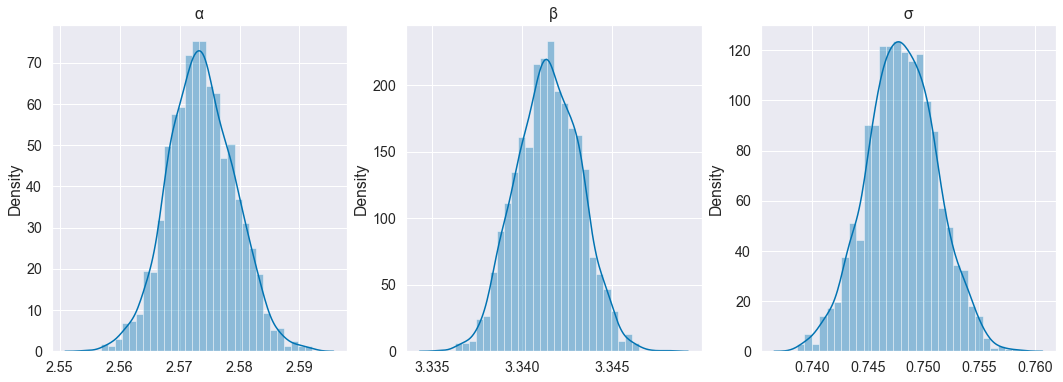

In [57]:
plot_distributions(model)

In [47]:
model.eval()
alpha, beta, sigma = model.mean
α_hat = float(alpha)
β_hat = float(beta)
σ_hat = float(torch.log(1 + torch.exp(sigma)))

print(f'Actual α = {α_actual:.2f} | Predicted α = {α_hat:.2f}')
print(f'Actual β = {β_actual:.2f} | Predicted β = {β_hat:.2f}')
print(f'Actual σ = {σ_actual:.2f} | Predicted σ = {σ_hat:.2f}')

Actual α = 2.60 | Predicted α = 2.57
Actual β = 3.30 | Predicted β = 3.34
Actual σ = 0.70 | Predicted σ = 0.75


In [18]:
y_hat, _ = model(x_test, sample=False)

In [19]:
def plot_results(x, y, y_sample, y_pred, y_pred_sample):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=2, label='Actual line')
    ax.plot(x.flatten(), y_pred.flatten(), '-', color=palette[1], linewidth=2, label='Predicted line')
    ax.scatter(x.flatten(), y_sample.flatten(), color=palette[0], label='Actual samples')
    ax.scatter(x.flatten(), y_pred_sample.flatten(), color=palette[1], label='Predicted samples')
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

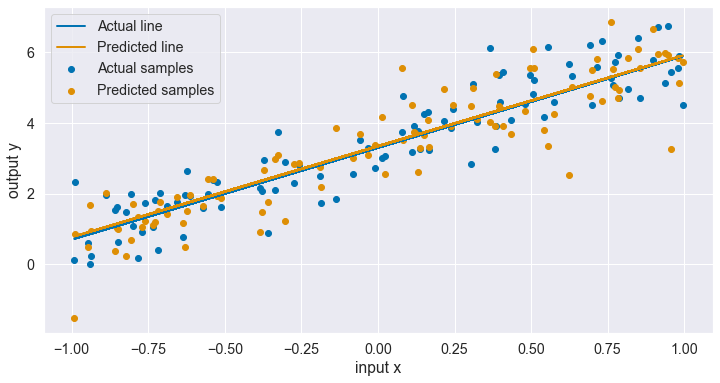

In [20]:
plot_results(
    x_test.detach().numpy(), 
    α_actual * x_test.detach().numpy() + β_actual, 
    y_test.detach().numpy(), 
    α_hat * x_test.detach().numpy() + β_hat, 
    y_hat.sample().detach().numpy()
);

## Plot uncertainty

In [63]:
def sample_parameters(model, n_samples=100):
    model.eval()
    mean = model.mean.detach()
    sigma = torch.log(1 + torch.exp(model.sigma)).detach()
    
    params = np.zeros((n_samples, 3))
    for i, param in enumerate(['α', 'β', 'σ']):
        if param == 'σ':
            m = torch.log(1 + torch.exp(mean[i]))
        else:
            m = mean[i]
        
        s = sigma[i]
        dist = torch.distributions.Normal(m, s)
        
        params[:,i] = dist.sample(torch.Size((n_samples,))).detach().numpy().flatten()
        
    return params

In [83]:
params = sample_parameters(model, n_samples=1000)
params.shape

(1000, 3)

In [109]:
def make_predictions(params, x):
    std_aleatoric = np.mean(params[:,2])
    
    lines = np.zeros((len(x), len(params)))
    
    for sample_number in range(len(params)):
        lines[:,sample_number] = (params[sample_number, 0] * x + params[sample_number,1]).flatten()
    
    predictions = np.mean(lines, axis=1)
    std_epistemic = np.std(lines, axis=1)
    
    std = std_epistemic + std_aleatoric
    
    return predictions, std

In [123]:
def plot_uncertainty(x, y, y_pred, y_err):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(x.flatten(), y.flatten(), '-', color=palette[0], linewidth=2, label='Actual line')
    ax.plot(x.flatten(), y_pred.flatten(), '-', color=palette[1], linewidth=2, label='Predicted line')
    ax.fill_between(
        x.flatten(),
        y_pred.flatten() + 2 * y_err,
        y_pred.flatten() - 2 * y_err,
        color=palette[1],
        alpha=0.3,
    )
    ax.set_xlabel('input x')
    ax.set_ylabel('output y')
    ax.legend()
    return ax

58.40133088282731


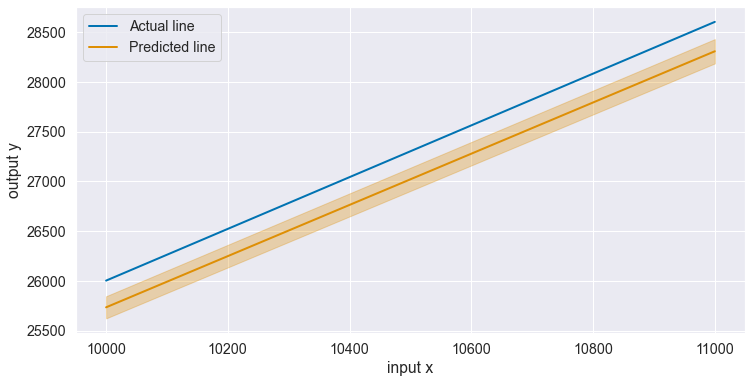

In [128]:
min_ = 10000
max_ = min_ + 1000
x_new, y_new, _ = generate_samples(α_actual, β_actual, σ_actual, min_x=min_, max_x=max_)
predictions, std = make_predictions(params, x_new)

print(np.mean(std))

plot_uncertainty(x_new, y_new, predictions, std);

552.5717687488561


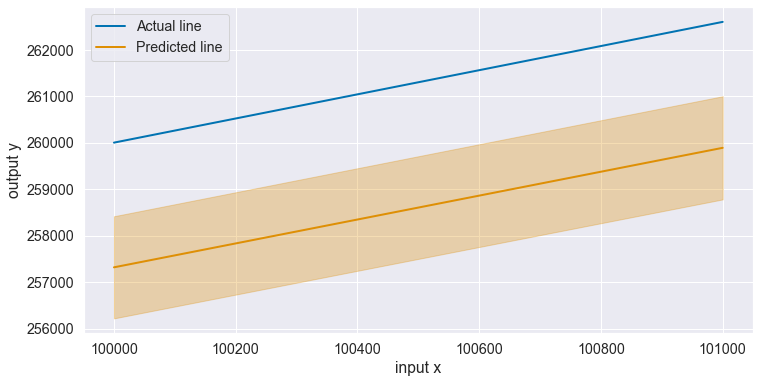

In [129]:
min_ = 100000
max_ = min_ + 1000
x_new, y_new, _ = generate_samples(α_actual, β_actual, σ_actual, min_x=min_, max_x=max_)
predictions, std = make_predictions(params, x_new)

print(np.mean(std))

plot_uncertainty(x_new, y_new, predictions, std);